In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.models import load_model

In [3]:
with open(os.path.join('features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [4]:

with open(os.path.join('captions.csv'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [5]:
with open(os.path.join('captions.csv'), 'r') as f:
    next(f)
    captions_doc = f.read()
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/5001 [00:00<?, ?it/s]

In [6]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
        # take one caption at a time
            caption = captions[i]
        # preprocessing steps
        # convert to lowercase
            caption = caption.lower()
        # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
        # delete additional spaces
            caption = caption.replace('\s+', ' ')
        # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\BalaDurga\AppData\Local\Temp\ipykernel_4660\919086354.py:12: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [7]:
mapping['1019077836_6fc9b15408']

['A brown dog chases the water from a sprinkler on a lawn .',
 'a brown dog plays with the hose .',
 'A brown dog running on a lawn near a garden hose',
 'A dog is playing with a hose .',
 'Large brown dog running away from the sprinkler in the grass .']

In [8]:
clean(mapping)

In [9]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [10]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [11]:

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1


In [12]:
vocab_size


3216

In [13]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

32

In [14]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.96)
train = image_ids[:split]
test = image_ids[split:]

In [15]:


from keras.models import Model
from keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from keras.utils import plot_model

# Define model parameters
max_length = 32 # Example value, replace with actual max_length
vocab_size = 3216 # Example value, replace with actual vocab_size

# Image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Compile the model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')


In [16]:
mdl=load_model("f1_model.keras")

C:\Users\BalaDurga\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [17]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [18]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [19]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()



In [20]:
for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)


  0%|          | 0/40 [00:00<?, ?it/s]

In [21]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join("images" ,image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
   # print('---------------------Actual---------------------')
   # for caption in captions:
      #  print(caption)
    # predict the caption
    y_pred = predict_caption(mdl, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

--------------------Predicted--------------------
startseq two horses are pulling two horses in the snow endseq


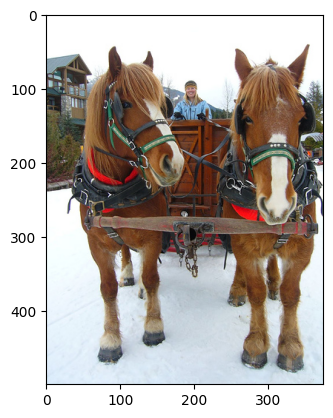

In [22]:
generate_caption('109202801_c6381eef15.jpg')

--------------------Predicted--------------------
startseq boy in red shirt is playing in the street endseq


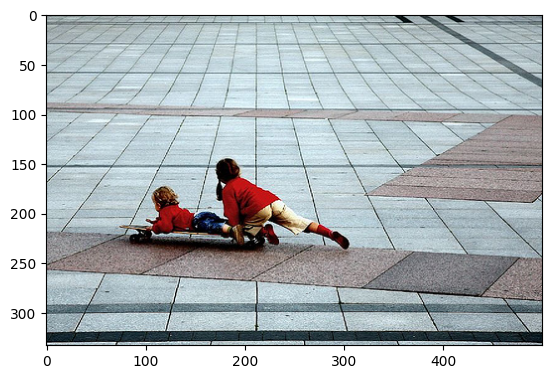

In [30]:
generate_caption('2090545563_a4e66ec76b.jpg')

In [24]:
# from keras.models import load_model
vgg_model = VGG16()
# model = load_model("saved_model.h5", compile=True)
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs,
                  outputs=vgg_model.layers[-2].output)

In [25]:
image_path = '109202801_c6381eef15.jpg'
#image_path="/content/drive/MyDrive/flicker1k/flickr1k/test_img1.jpg"
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image from vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
print(feature)
text=predict_caption(mdl, feature, tokenizer, max_length)
text

[[0. 0. 0. ... 0. 0. 0.]]


'startseq two horses are pulling two horses in the snow endseq'

In [26]:

# Remove 'startseq' and 'endseq'
cleaned_text = text.replace("startseq", "").replace("endseq", "").strip()


In [27]:
cleaned_text

'two horses are pulling two horses in the snow'

In [28]:
from googletrans import Translator

# Initialize the translator
translator = Translator()

# Text to be translated
text =cleaned_text
languages = [ 'telugu','english','hindi','tamil'] 
translations = {}
for lang in languages:
    translated = translator.translate(text, dest=lang)
    translations[lang] = translated.text

# Print the translations
for lang, translation in translations.items():
    print(f"{lang}: {translation}")
    if lang=='english':
        x=translation
    elif lang=='telugu':
        y=translation

telugu: రెండు గుర్రాలు మంచులో రెండు గుర్రాలను లాగుతున్నాయి
english: two horses are pulling two horses in the snow
hindi: दो घोड़े बर्फ में दो घोड़ों को खींच रहे हैं
tamil: இரண்டு குதிரைகள் பனியில் இரண்டு குதிரைகளை இழுக்கின்றன


In [29]:
import pyttsx3
engine = pyttsx3.init()

# Set properties (optional)
engine.setProperty('rate', 140)  # Speed of speech
engine.setProperty('volume', 1.0)  # Volume level (0.0 to 1.0)

# Text to be converted to speech
text = y

# Convert text to speech
engine.say(text)

# Wait for the speech to finish
engine.runAndWait()